In [ ]:
!pip install -q datasets==2.21.0 requests torch peft bitsandbytes transformers==4.43.1 trl accelerate sentencepiece

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.7/43.7 kB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 527.3/527.3 kB 15.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.4/9.4 MB 14.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 122.4/122.4 MB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 316.6/316.6 kB 14.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 177.6/177.6 kB 10.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 25.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 109.8/109.8 kB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 2.9 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour i

In [ ]:
from huggingface_hub import login
from google.colab import userdata
from datasets import load_dataset, Dataset, DatasetDict, load_from_disk
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from typing import Optional
from transformers import AutoTokenizer
import re
from datetime import datetime
from tqdm import tqdm
from concurrent.futures import ProcessPoolExecutor, ThreadPoolExecutor
from collections import Counter, defaultdict
import random
import pickle
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import CountVectorizer
from gensim.models import Word2Vec
from gensim.utils import simple_preprocess
from sklearn.svm import LinearSVR
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
import json
import math
import os
import torch
import transformers
from transformers import AutoModelForCausalLM, AutoTokenizer, BitsAndBytesConfig, TrainingArguments, set_seed
from peft import LoraConfig, PeftModel
import wandb
from trl import SFTConfig, DataCollatorForCompletionOnlyLM, SFTTrainer

In [ ]:
hf_token = userdata.get('HF_TOKEN_WRITE')
login(hf_token, add_to_git_credential=True)

In [ ]:
CHUNK_SIZE = 1000
MIN_PRICE = 0.5
MAX_PRICE = 999.49

class ItemLoader:


    def __init__(self, name):
        self.name = name
        self.dataset = None

    def from_datapoint(self, datapoint):

        try:
            price_str = datapoint['price']
            if price_str:
                price = float(price_str)
                if MIN_PRICE <= price <= MAX_PRICE:
                    item = Item(datapoint, price)
                    return item if item.include else None
        except ValueError:
            return None

    def from_chunk(self, chunk):

        batch = []
        for datapoint in chunk:
            result = self.from_datapoint(datapoint)
            if result:
                batch.append(result)
        return batch

    def chunk_generator(self):

        size = len(self.dataset)
        for i in range(0, size, CHUNK_SIZE):
            yield self.dataset.select(range(i, min(i + CHUNK_SIZE, size)))

    def load_in_parallel(self, workers):

        results = []
        chunk_count = (len(self.dataset) // CHUNK_SIZE) + 1
        with ProcessPoolExecutor(max_workers=workers) as pool:
            for batch in tqdm(pool.map(self.from_chunk, self.chunk_generator()), total=chunk_count):
                results.extend(batch)
        for result in results:
            result.category = self.name
        return results

    def load(self, workers=8):

        start = datetime.now()
        print(f"Loading dataset {self.name}", flush=True)
        self.dataset = load_dataset("McAuley-Lab/Amazon-Reviews-2023", f"raw_meta_{self.name}", split="full", trust_remote_code=True)
        results = self.load_in_parallel(workers)
        finish = datetime.now()
        print(f"Completed {self.name} with {len(results):,} datapoints in {(finish-start).total_seconds()/60:.1f} mins", flush=True)
        return results

In [ ]:
GREEN = "\033[92m"
YELLOW = "\033[93m"
RED = "\033[91m"
RESET = "\033[0m"
COLOR_MAP = {"red":RED, "orange": YELLOW, "green": GREEN}

In [ ]:
dataset = load_from_disk('/content/drive/MyDrive/my_dataset_mini_25k')


In [ ]:
train = dataset['train']
test = dataset['test']

In [ ]:
train[0]

{'text': 'How much does this cost to the nearest dollar?\n\nWagner Brake Disc Brake Rotor\nWagner® premium brake rotors are engineered with technology focused on providing maximum performance, corrosion resistance and ease of installation. Pair Wagner rotors with Wagner brake pads for optimal performance. ENGINEERED FOR PERFORMANCE -- OE-specific vane design provides effective braking power and heat dissipation while controlling noise, vibration and harshness PREMIUM PROTECTION -- E-Shield protective coating is applied to non-braking surfaces to inhibit corrosion TURNED AND SMOOTH FINISH -- Requires less pad break-in time and aids in proper bedding EASY INSTALLATION -- Rotors are packaged in a Vapor Corrosion Inhibitor bag, eliminating the need for an oil coating which reduces prep time PROPER BALANCE -- Spin balanced and cut to limit vibration for improving stability and control PERF\n\nPrice is $65.00',
 'price': 65.43}

In [ ]:
class Tester:

    def __init__(self, predictor, data, title=None, size=250):
        self.predictor = predictor
        self.data = data
        self.title = title or predictor.__name__.replace("_", " ").title()
        self.size = size
        self.guesses = []
        self.truths = []
        self.errors = []
        self.sles = []
        self.colors = []

    def color_for(self, error, truth):
        if error<40 or error/truth < 0.2:
            return "green"
        elif error<80 or error/truth < 0.4:
            return "orange"
        else:
            return "red"

    def run_datapoint(self, i):
        datapoint = self.data[i]
        guess = self.predictor(datapoint["text"])
        truth = datapoint["price"]
        error = abs(guess - truth)
        log_error = math.log(truth+1) - math.log(guess+1)
        sle = log_error ** 2
        color = self.color_for(error, truth)
        title = datapoint["text"].split("\n\n")[1][:20] + "..."
        self.guesses.append(guess)
        self.truths.append(truth)
        self.errors.append(error)
        self.sles.append(sle)
        self.colors.append(color)
        print(f"{COLOR_MAP[color]}{i+1}: Guess: ${guess:,.2f} Truth: ${truth:,.2f} Error: ${error:,.2f} SLE: {sle:,.2f} Item: {title}{RESET}")

    def chart(self, title):
        max_error = max(self.errors)
        plt.figure(figsize=(12, 8))
        max_val = max(max(self.truths), max(self.guesses))
        plt.plot([0, max_val], [0, max_val], color='deepskyblue', lw=2, alpha=0.6)
        plt.scatter(self.truths, self.guesses, s=3, c=self.colors)
        plt.xlabel('Ground Truth')
        plt.ylabel('Model Estimate')
        plt.xlim(0, max_val)
        plt.ylim(0, max_val)
        plt.title(title)
        plt.show()

    def report(self):
        average_error = sum(self.errors) / self.size
        rmsle = math.sqrt(sum(self.sles) / self.size)
        hits = sum(1 for color in self.colors if color=="green")
        title = f"{self.title} Error=${average_error:,.2f} RMSLE={rmsle:,.2f} Hits={hits/self.size*100:.1f}%"
        self.chart(title)

    def run(self):
        self.error = 0
        for i in range(self.size):
            self.run_datapoint(i)
        self.report()

    @classmethod
    def test(cls, function, data):
        cls(function, data).run()

In [ ]:
BASE_MODEL = "meta-llama/Meta-Llama-3.1-8B"
LLAMA_3_1 = "meta-llama/Meta-Llama-3.1-8B"
QWEN_2_5 = "Qwen/Qwen2.5-7B"
GEMMA_2 = "google/gemma-2-9b"
PHI_3 = "microsoft/Phi-3-medium-4k-instruct"

MAX_SEQUENCE_LENGTH = 182
QUANT_4_BIT = True

LORA_R = 32
LORA_ALPHA = 64
TARGET_MODULES = ["q_proj", "v_proj", "k_proj", "o_proj"]

In [ ]:
def investigate_tokenizer(model_name):
  print("Investigating tokenizer for", model_name)
  tokenizer = AutoTokenizer.from_pretrained(model_name, trust_remote_code=True)
  for number in [0, 1, 10, 100, 999, 1000]:
    tokens = tokenizer.encode(str(number), add_special_tokens=False)
    print(f"The tokens for {number}: {tokens}")

In [ ]:
investigate_tokenizer(PHI_3)

Investigating tokenizer for microsoft/Phi-3-medium-4k-instruct


tokenizer_config.json:   0%|          | 0.00/3.15k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/500k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.84M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/293 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/568 [00:00<?, ?B/s]

The tokens for 0: [29871, 29900]
The tokens for 1: [29871, 29896]
The tokens for 10: [29871, 29896, 29900]
The tokens for 100: [29871, 29896, 29900, 29900]
The tokens for 999: [29871, 29929, 29929, 29929]
The tokens for 1000: [29871, 29896, 29900, 29900, 29900]


In [ ]:
investigate_tokenizer(QWEN_2_5)

Investigating tokenizer for Qwen/Qwen2.5-7B


tokenizer_config.json:   0%|          | 0.00/7.23k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/2.78M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/1.67M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/7.03M [00:00<?, ?B/s]

The tokens for 0: [15]
The tokens for 1: [16]
The tokens for 10: [16, 15]
The tokens for 100: [16, 15, 15]
The tokens for 999: [24, 24, 24]
The tokens for 1000: [16, 15, 15, 15]


In [ ]:
investigate_tokenizer(GEMMA_2)

Investigating tokenizer for google/gemma-2-9b


tokenizer_config.json:   0%|          | 0.00/46.4k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/4.24M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.5M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/636 [00:00<?, ?B/s]

The tokens for 0: [235276]
The tokens for 1: [235274]
The tokens for 10: [235274, 235276]
The tokens for 100: [235274, 235276, 235276]
The tokens for 999: [235315, 235315, 235315]
The tokens for 1000: [235274, 235276, 235276, 235276]


In [ ]:
investigate_tokenizer(LLAMA_3_1)

Investigating tokenizer for meta-llama/Meta-Llama-3.1-8B
The tokens for 0: [15]
The tokens for 1: [16]
The tokens for 10: [605]
The tokens for 100: [1041]
The tokens for 999: [5500]
The tokens for 1000: [1041, 15]


In [ ]:
if QUANT_4_BIT:
  quant_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_compute_dtype=torch.bfloat16,
    bnb_4bit_quant_type="nf4"
  )
else:
  quant_config = BitsAndBytesConfig(
    load_in_8bit=True,
    bnb_8bit_compute_dtype=torch.bfloat16
  )

In [ ]:
tokenizer = AutoTokenizer.from_pretrained(BASE_MODEL, trust_remote_code=True)
tokenizer.pad_token = tokenizer.eos_token
tokenizer.padding_side = "right"

base_model = AutoModelForCausalLM.from_pretrained(
    BASE_MODEL,
    quantization_config=quant_config,
    device_map="auto",
)
base_model.generation_config.pad_token_id = tokenizer.eos_token_id

print(f"Memory footprint: {base_model.get_memory_footprint() / 1e9:.1f} GB")

tokenizer_config.json:   0%|          | 0.00/50.5k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.09M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/73.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/826 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/23.9k [00:00<?, ?B/s]

model-00001-of-00004.safetensors:   0%|          | 0.00/4.98G [00:00<?, ?B/s]

model-00002-of-00004.safetensors:   0%|          | 0.00/5.00G [00:00<?, ?B/s]

model-00003-of-00004.safetensors:   0%|          | 0.00/4.92G [00:00<?, ?B/s]

model-00004-of-00004.safetensors:   0%|          | 0.00/1.17G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/185 [00:00<?, ?B/s]

Memory footprint: 5.6 GB


In [ ]:
def extract_price(s):
    if "Price is $" in s:
      contents = s.split("Price is $")[1]
      contents = contents.replace(',','').replace('$','')
      match = re.search(r"[-+]?\d*\.\d+|\d+", contents)
      return float(match.group()) if match else 0
    return 0

In [ ]:
extract_price("Price is $999, making it one of the most affordable premium models available.")

999.0

In [ ]:
def model_predict(prompt):
    set_seed(42)
    inputs = tokenizer.encode(prompt, return_tensors="pt").to("cuda")
    attention_mask = torch.ones(inputs.shape, device="cuda")
    outputs = base_model.generate(inputs, max_new_tokens=4, attention_mask=attention_mask, num_return_sequences=1)
    response = tokenizer.decode(outputs[0])
    return extract_price(response)

In [ ]:
model_predict(test[0]['text'])

1800.0

In [ ]:
test[0]['price']

319.97

1: Guess: $25.00 Truth: $69.25 Error: $44.25 SLE: 0.99 Item: Lund Catch-It Vinyl ...
2: Guess: $25.00 Truth: $189.99 Error: $164.99 SLE: 3.98 Item: MZORANGE Tail Light ...
3: Guess: $25.99 Truth: $17.19 Error: $8.80 SLE: 0.16 Item: X AUTOHAUX Rear Tail...
4: Guess: $25.00 Truth: $48.88 Error: $23.88 SLE: 0.42 Item: PGTOPONE Red LED Rea...
5: Guess: $25.00 Truth: $27.99 Error: $2.99 SLE: 0.01 Item: Front Bumper for THE...
6: Guess: $25.00 Truth: $143.27 Error: $118.27 SLE: 2.94 Item: Detroit Axle - 12.64...
7: Guess: $25.00 Truth: $64.79 Error: $39.79 SLE: 0.86 Item: NUVISION LIGHTING Su...
8: Guess: $1,999.00 Truth: $231.93 Error: $1,767.07 SLE: 4.62 Item: EBC Superstreet Brak...
9: Guess: $25.00 Truth: $29.95 Error: $4.95 SLE: 0.03 Item: Car Console Covers P...
10: Guess: $25.00 Truth: $139.99 Error: $114.99 SLE: 2.86 Item: Motor City Euro Clea...
11: Guess: $1,800.00 Truth: $940.36 Error: $859.64 SLE: 0.42 Item: Associated Equipment...
12: Guess: $25.00 Truth: $33.00 Error: $8.00 SLE

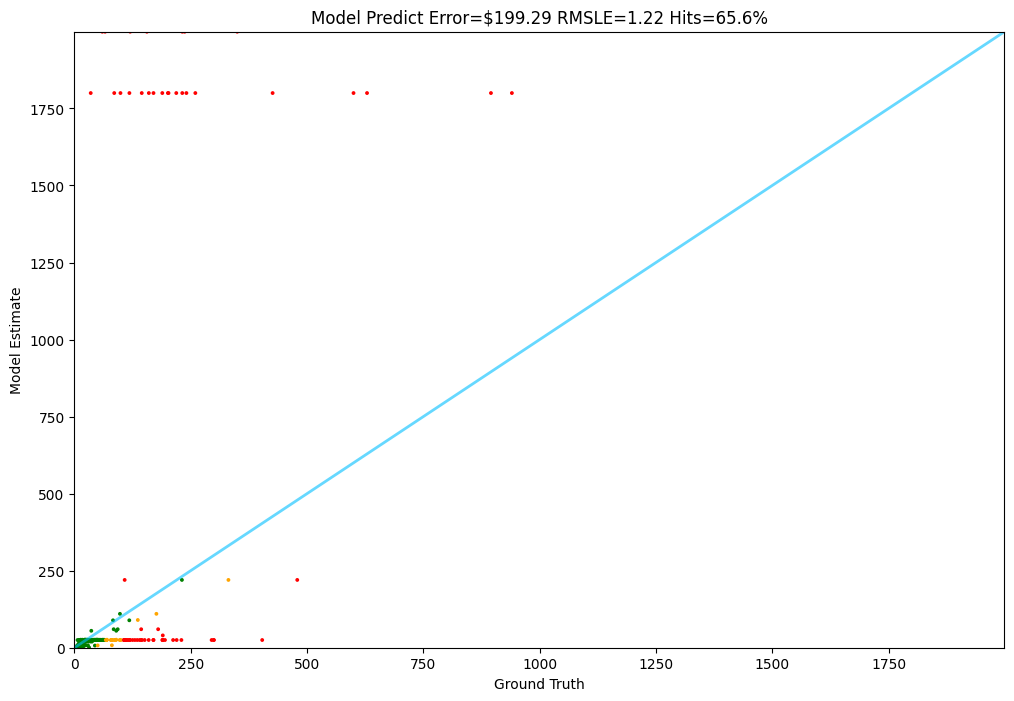

In [ ]:
Tester.test(model_predict, test)